In [1]:
import os
import pickle
import re
from typing import Tuple
import ast

import click
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm

from covidcf.data.base import ensure_data_dirs, DATA_RAW_PATH, DATA_PROCESSED_PATH

In [2]:
os.chdir('..')

In [9]:
def get_patient(raw_data, pid: int):
    return raw_data[pid]


def get_patient_features(patient_data):
    DOWN_ARROW = "#8595;"
    UP_ARROW = "#8593;"
    split_tables = patient_data[-1]
    basic_info = split_tables.split("Basic Information")[1]
    found = re.findall(
        r"\$(?P<name>[^\$]+)@(?P<abbr>[^\$]+)@(?P<value>[^\$&]+)&?(?P<change>[^\$]+)?@(?P<normal>[^\$]+)",
        basic_info)

    df = pd.DataFrame(found, columns=["Name", "Abbreviation", "Value", "Change", "Normal"])
    # TODO: Check if UP and DOWN arrow ar correct
    df.Change = df.Change.str.replace(DOWN_ARROW, "-1").replace(UP_ARROW, "1").replace("", "0")
    pd.Change = pd.to_numeric(df.Change)
    df.Normal = df.Normal.str.replace("<", "0-")

    # !!!!
    df.Value = df.Value.str.replace("<", "")
    df.Value = df.Value.str.replace(">", "")
    df[["NormalMin", "NormalMax"]] = df.Normal.str.extract(r"([\d\.]+)\-([\d\.]+).+")
    df.drop(columns=['Normal'], inplace=True)

    df.Value = pd.to_numeric(df.Value)
    df.NormalMin = pd.to_numeric(df.NormalMin)
    df.NormalMax = pd.to_numeric(df.NormalMax)

    return df


In [10]:
def process_ictcf():
    ensure_data_dirs()
    RAW_ICTCF_PATH = os.path.join(DATA_RAW_PATH, 'patient.txt')

    RAW_VIS_TRAIN = os.path.join(DATA_RAW_PATH, 'predictions__train_ens_features.p.csv')
    RAW_VIS_VAL = os.path.join(DATA_RAW_PATH, 'predictions__val_ens_features.p.csv')
    RAW_VIS_TEST = os.path.join(DATA_RAW_PATH, 'predictions__test_ens_features2.p.csv')

    if not os.path.exists(RAW_ICTCF_PATH):
        print('patient.txt missing, downloading...')
        res = requests.get("http://ictcf.biocuckoo.cn/patient/patient.txt")
        text = res.text
        with open(RAW_ICTCF_PATH, 'wb') as f:
            f.write(res.content)
    else:
        with open(RAW_ICTCF_PATH, 'r', encoding='utf-8') as f:
            text = f.read()

    raw_data = [row.split("\t") for row in text.split("\n")]

    patients = {}
    print('Processing patient data...')
    for i in tqdm(range(len(raw_data) - 1)):
        features = get_patient_features(get_patient(raw_data, i))
        patients[i] = features

    df = pd.concat(patients)
    df["Patient"] = df.index.get_level_values(0)
    return df

In [12]:
ictcf = process_ictcf()

  1%|▋                                                       | 19/1521 [00:00<00:08, 186.27it/s]

Processing patient data...


100%|██████████████████████████████████████████████████████| 1521/1521 [00:07<00:00, 214.10it/s]


In [14]:
from covidcf.data.ictcf import load_ictcf

In [16]:
df, X, y, = load_ictcf()

In [25]:
df[df.Target.Metadata_Morbidity.str.lower().str.contains('suspected')].Target.pcr.value_counts()

Negative    248
Positive     51
Name: pcr, dtype: int64

In [41]:
df[~df.Target.Metadata_Morbidity.str.contains('confirmed') & df.Target.Metadata_Morbidity.str.contains('Suspected')].Target.pcr.value_counts()

Negative    248
Positive      0
Name: pcr, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Control'),
  Text(1, 0, 'Control (Community-acquired pneumonia)'),
  Text(2, 0, 'Critically ill'),
  Text(3, 0, 'Mild'),
  Text(4, 0, 'Regular'),
  Text(5, 0, 'Severe'),
  Text(6, 0, 'Suspected'),
  Text(7, 0, 'Suspected (COVID-19-confirmed later)')])

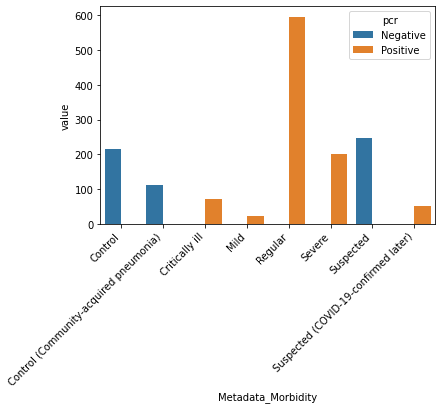

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
pcrs_per_group = df.Target.pcr.groupby(df.Target.Metadata_Morbidity).value_counts().to_frame().rename(columns={'pcr': 'value'}).reset_index()
sns.barplot(data=pcrs_per_group, x='Metadata_Morbidity', y='value', hue='pcr')
plt.xticks(rotation=45, ha='right')